In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import *
from torchvision import datasets
from torchvision.transforms import *

In [2]:
# Download MNIST dataset
full_dataset = datasets.MNIST(
    root="data",
    download=True,
    transform=ToTensor(),
)

In [3]:
batch_size = 64

# Create data loaders.
dataloader = DataLoader(full_dataset, batch_size=batch_size)

# DELME
for X, y in dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


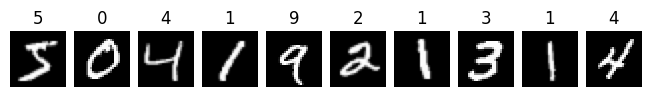

In [4]:
# Show some examples of the dataset

(fig,ax) = plt.subplots(1, 10, constrained_layout=True)
ds = full_dataset
for j in range(10):
    ax[j].imshow(ds[j][0][0], cmap="gray")
    ax[j].set_axis_off()
    ax[j].set_title(ds[j][1])
plt.axis('off')
plt.show()

In [5]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [34]:
# Define model
class AutoencoderMNIST(nn.Module):
    bottleneck = 10
    
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.unflatten = nn.Unflatten(1, (1,28,28))
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, self.bottleneck)
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.bottleneck, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.flatten(x)
        coded = self.encoder(x)
        return coded

    def decode(self, x):
        x = self.decoder(x)
        decoded = self.unflatten(x)
        return decoded

    def forward(self, x):
        return self.decode( self.encode(x) )

In [ ]:
# OUTDATED

import torch.nn.functional as F

class SmallMNISTCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [35]:
#model = ClassicMNIST().to(device)
model = AutoencoderMNIST().to(device)
print(model)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

AutoencoderMNIST(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (unflatten): Unflatten(dim=1, unflattened_size=(1, 28, 28))
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [29]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, X)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
# DON'T NEED THIS

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, X).item()
    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f}")

In [36]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 0.231288  [   64/60000]
loss: 0.061588  [ 6464/60000]
loss: 0.038172  [12864/60000]
loss: 0.036706  [19264/60000]
loss: 0.031250  [25664/60000]
loss: 0.026985  [32064/60000]
loss: 0.023372  [38464/60000]
loss: 0.024661  [44864/60000]
loss: 0.021263  [51264/60000]
loss: 0.021360  [57664/60000]
Epoch 2
-------------------------------
loss: 0.022253  [   64/60000]
loss: 0.018342  [ 6464/60000]
loss: 0.018256  [12864/60000]
loss: 0.019577  [19264/60000]
loss: 0.018686  [25664/60000]
loss: 0.019331  [32064/60000]
loss: 0.017431  [38464/60000]
loss: 0.019229  [44864/60000]
loss: 0.016991  [51264/60000]
loss: 0.017491  [57664/60000]
Epoch 3
-------------------------------
loss: 0.018366  [   64/60000]
loss: 0.015515  [ 6464/60000]
loss: 0.015419  [12864/60000]
loss: 0.016533  [19264/60000]
loss: 0.016513  [25664/60000]
loss: 0.017447  [32064/60000]
loss: 0.015241  [38464/60000]
loss: 0.017412  [44864/60000]
loss: 0.015272  [51264/60000]
loss: 0.01

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

In [ ]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])


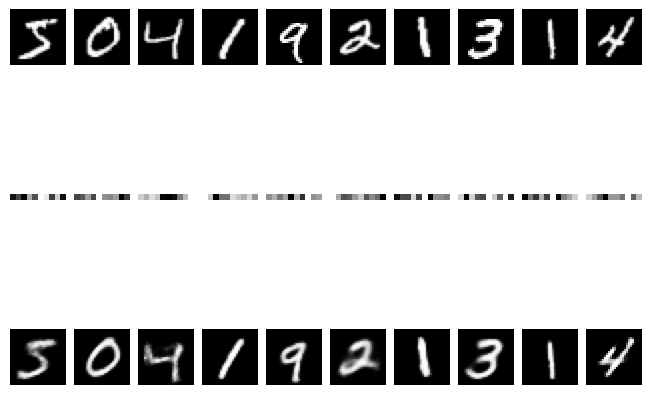

In [40]:
# Show some examples of the dataset

model.eval()
(fig,ax) = plt.subplots(3, 10, constrained_layout=True)
ds = full_dataset
for j in range(10):
    x, _ = ds[j]
    x = x[None,:].to(device)
    with torch.no_grad():
        z = model.encode(x)
        print(z.shape)
        y = model.decode(z)
    
    ax[0,j].imshow(ds[j][0][0], cmap="gray")
    ax[0,j].set_axis_off()
    ax[1,j].imshow(z[None,0].cpu(), cmap="gray")
    ax[1,j].set_axis_off()
    ax[2,j].imshow(y[0][0].cpu(), cmap="gray")
    ax[2,j].set_axis_off()
    
plt.axis('off')
plt.show()

In [98]:
# determine mean and covariance of encoded data

all_data = torch.stack([x for (x,_) in full_dataset])
all_data = all_data.to(device)

model.eval()
with torch.no_grad():
    out = model.encode(all_data)
    out = out.cpu()

u = torch.mean(out,0)
S = torch.cov(out.T)

(L,Q)=torch.linalg.eigh(S)

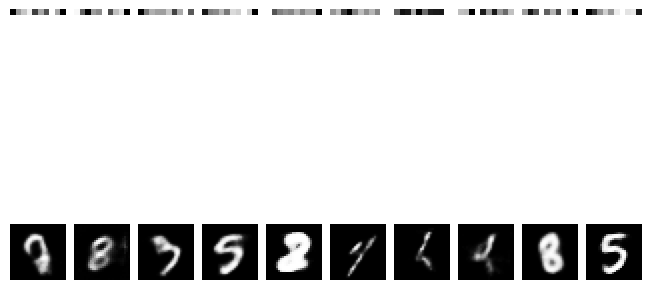

In [120]:
# generate some images from random encoded data

model.eval()
(fig,ax) = plt.subplots(2, 10, constrained_layout=True)
for j in range(10):
    z = torch.randn(10)
    z = u + Q@torch.sqrt(L)*z
    z = z[None,:].to(device)

    with torch.no_grad():
        y = model.decode(z)
    
    ax[0,j].imshow(z[None,0].cpu(), cmap="gray")
    ax[0,j].set_axis_off()
    ax[1,j].imshow(y[0][0].cpu(), cmap="gray")
    ax[1,j].set_axis_off()
    
plt.axis('off')
plt.show()